Idealised 2-D mantle convection problem inside an annulus
=====================================================================

In this tutorial, we analyse mantle flow in a 2-D annulus domain. We define our domain by the radii
of the inner ($r_{\text{min}}$) and outer ($r_{\text{max}}$) boundaries. These are chosen such that
the non-dimensional depth of the mantle, $z = r_{\text{max}} - r_{\text{min}} = 1$, and the ratio of
the inner and outer radii, $f=r_{\text{min}} / r_{\text{max}} = 0.55$, thus approximating the ratio
between the radii of Earth's surface and core-mantle-boundary (CMB). Specifically, we set
$r_{\text{min}} = 1.22$ and $r_{\text{max}} = 2.22$.

This example focusses on differences between running simulations in a 2-D annulus and 2-D Cartesian domain. These can be summarised as follows:
1. The geometry of the problem - i.e. the computational mesh.
2. The radial direction of gravity (as opposed to the vertical direction in a Cartesian domain).
3. Initialisation of the temperature field in a different domain.
4. With free-slip boundary conditions on both boundaries, this case incorporates a (rotational) velocity nullspace, as well as a pressure nullspace.

The example is configured at $Ra = 1e5$. Boundary conditions are free-slip at the surface and base of the domain.


The first step is to import the gadopt module, which
provides access to Firedrake and associated functionality.
We also import pyvista, which is used for plotting vtk output.

In [1]:
from gadopt import *

In [2]:
import pyvista as pv

We next set up the mesh, function spaces, and specify functions to hold our solutions,
as with our previous tutorials.

We generate a circular manifold mesh (with 128 elements) and extrude in the radial direction,
using the optional keyword argument `extrusion_type`, forming 32 layers. To better represent the
curvature of the domain and ensure accuracy of our quadratic representation of velocity, we
approximate the curved cylindrical shell domain quadratically, using the optional keyword argument `degree`$=2$.
Because this problem is not formulated in a Cartesian geometry, we set the `mesh.cartesian`
attribute to False. This ensures the correct configuration of a radially inward vertical direction.

In [3]:
rmin, rmax, ncells, nlayers = 1.22, 2.22, 128, 32
mesh1d = CircleManifoldMesh(ncells, radius=rmin, degree=2)  # construct a circle mesh
mesh = ExtrudedMesh(mesh1d, layers=nlayers, extrusion_type='radial')  # extrude into a cylinder
mesh.cartesian = False
boundary = get_boundary_ids(mesh)

V = VectorFunctionSpace(mesh, "CG", 2)  # Velocity function space (vector)
W = FunctionSpace(mesh, "CG", 1)  # Pressure function space (scalar)
Q = FunctionSpace(mesh, "CG", 2)  # Temperature function space (scalar)
Z = MixedFunctionSpace([V, W])  # Mixed function space.

z = Function(Z)  # A field over the mixed function space Z.
u, p = split(z)  # Returns symbolic UFL expression for u and p
z.subfunctions[0].rename("Velocity")
z.subfunctions[1].rename("Pressure")

We can now visualise the resulting mesh.

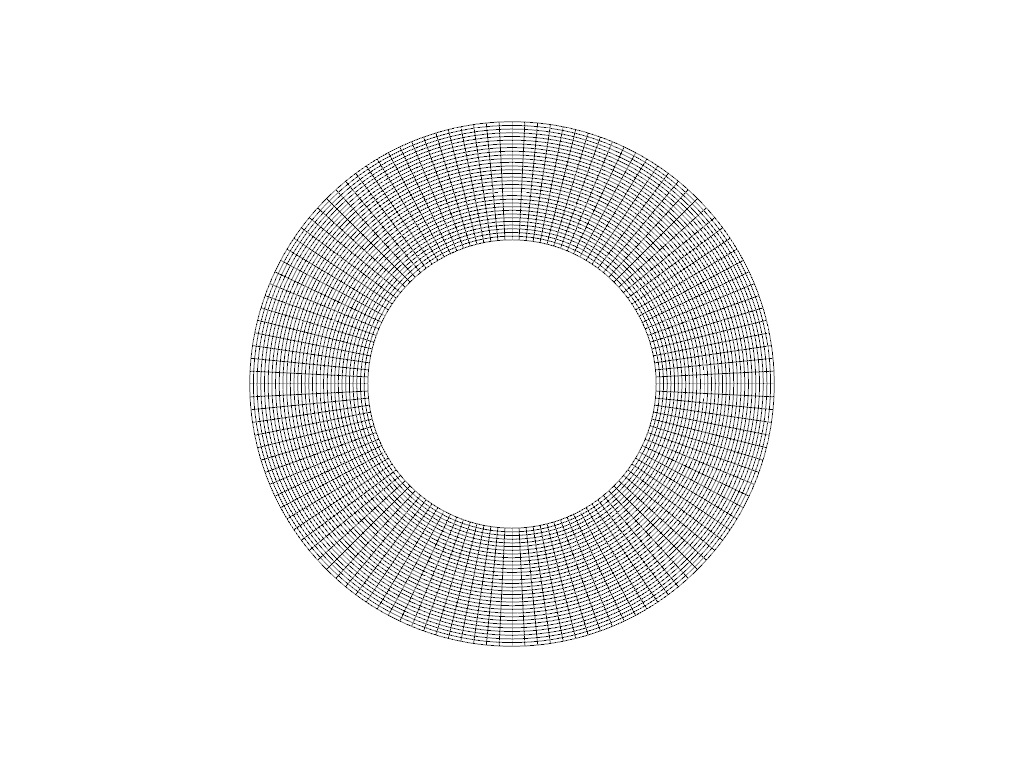

In [4]:
VTKFile("mesh.pvd").write(Function(V))
mesh_data = pv.read("mesh/mesh_0.vtu")
edges = mesh_data.extract_all_edges()
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(edges, color="black")
plotter.camera_position = "xy"
plotter.show(jupyter_backend="static", interactive=False)

We next specify the important constants for this problem, and set up the approximation.

In [5]:
Ra = Constant(1e5)  # Rayleigh number
approximation = BoussinesqApproximation(Ra)

As with the previous examples, we set up a *Timestep Adaptor*,
for controlling the time-step length (via a CFL
criterion) as the simulation advances in time. For the latter,
we specify the initial time, initial timestep $\Delta t$, and number of
timesteps. Given the low Rayleigh number, a steady-state tolerance is also specified,
allowing the simulation to exit when a steady-state has been achieved.

In [6]:
time = 0.0  # Initial time
delta_t = Constant(1e-7)  # Initial time-step
timesteps = 20000  # Maximum number of timesteps
t_adapt = TimestepAdaptor(delta_t, u, V, maximum_timestep=0.1, increase_tolerance=1.5)
steady_state_tolerance = 1e-7  # Used to determine if solution has reached a steady state.

We next set up and initialise our Temperature field.
We choose the initial temperature distribution to trigger upwelling of 4 equidistant plumes.
This initial temperature field is prescribed as:

$$T(x,y) = (r_{\text{max}} - r) + A\cos(4 \; atan2\ (y,x))  \sin(r-r_{\text{min}}) \pi)$$

where $A=0.02$ is the amplitude of the initial perturbation.

In [7]:
X = SpatialCoordinate(mesh)
T = Function(Q, name="Temperature")
r = sqrt(X[0]**2 + X[1]**2)
T.interpolate(rmax - r + 0.02*cos(4*atan2(X[1], X[0])) * sin((r - rmin) * pi))

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.ExtrudedMeshTopology object at 0x729b7c38cf80>, TensorProductElement(FiniteElement('Lagrange', interval, 2), FiniteElement('Lagrange', interval, 2), cell=TensorProductCell(interval, interval)), name=None), Mesh(VectorElement(TensorProductElement(FiniteElement('Lagrange', interval, 2), FiniteElement('Lagrange', interval, 1), cell=TensorProductCell(interval, interval)), dim=2), 6)), 31)

We can plot this initial temperature field:

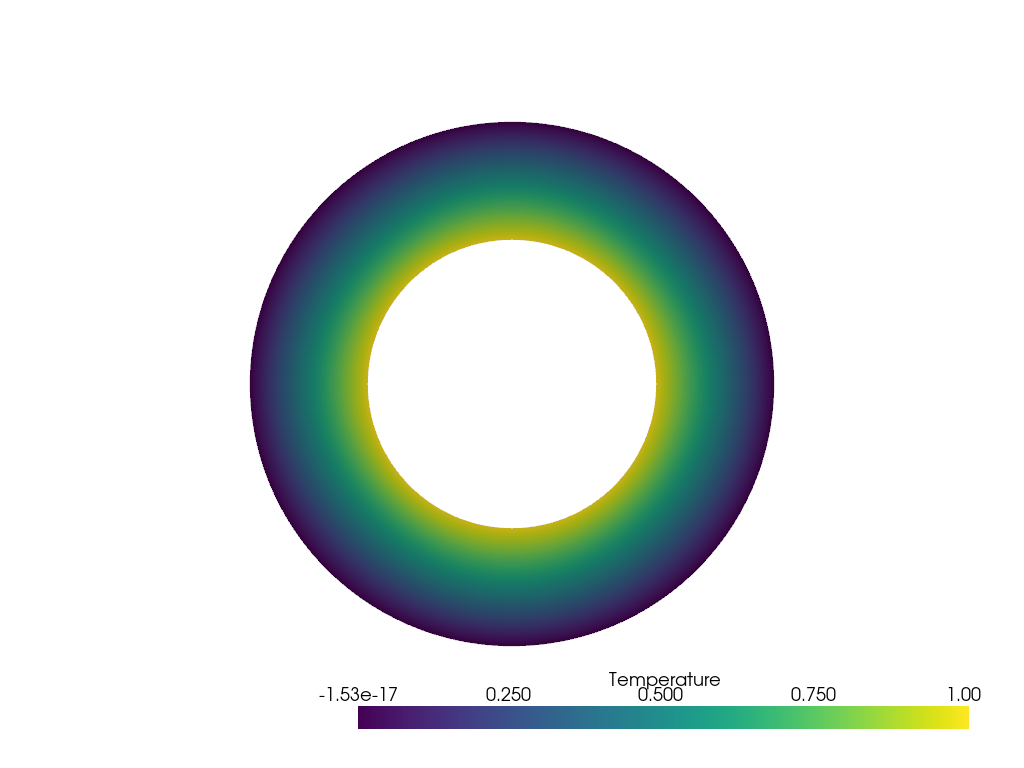

In [8]:
VTKFile("temp.pvd").write(T)
temp_data = pv.read("temp/temp_0.vtu")
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(temp_data)
plotter.camera_position = "xy"
plotter.show(jupyter_backend="static", interactive=False)

As noted above, with a free-slip boundary condition on both boundaries, one can add an arbitrary rotation
of the form $(-y, x)=r\hat{\mathbf{\theta}}$ to the velocity solution (i.e. this case incorporates a velocity nullspace,
as well as a pressure nullspace). These lead to null-modes (eigenvectors) for the linear system, rendering the resulting matrix singular.
In preconditioned Krylov methods these null-modes must be subtracted from the approximate solution at every iteration. We do that below,
setting up a nullspace object as we did in the previous tutorial, albeit speciying the `rotational` keyword argument to be True.
This removes the requirement for a user to configure these options, further simplifying the task of setting up a (valid) geodynamical simulation.

In [9]:
Z_nullspace = create_stokes_nullspace(Z, closed=True, rotational=True)

Given the increased computational expense (typically requiring more degrees of freedom) in a 2-D annulus domain, G-ADOPT defaults to iterative
solver parameters. As noted in our previous 3-D Cartesian tutorial, G-ADOPT's iterative solver setup is configured to use the GAMG preconditioner
for the velocity block of the Stokes system, to which we must provide near-nullspace information, which, in 2-D, consists of two rotational and two
translational modes.

In [10]:
Z_near_nullspace = create_stokes_nullspace(Z, closed=False, rotational=True, translations=[0, 1])

Boundary conditions are next specified. Boundary conditions for temperature are set to $T = 0$ at the surface ($r_{\text{max}}$) and $T = 1$
at the base ($r_{\text{min}}$). For velocity, we specify free‐slip conditions on both boundaries. We incorporate these <b>weakly</b> through
the <i>Nitsche</i> approximation. This illustrates a key advantage of the G-ADOPT framework: the user only specifies that the normal component
of velocity is zero and all required changes are handled under the hood.

In [11]:
stokes_bcs = {
    boundary.bottom: {'un': 0},
    boundary.top: {'un': 0},
}

temp_bcs = {
    boundary.bottom: {'T': 1.0},
    boundary.top: {'T': 0.0},
}

We next setup our output, in VTK format.
We also open a file for logging and calculate our diagnostic outputs.

In [12]:
output_file = VTKFile("output.pvd")
ref_file = VTKFile('reference_state.pvd')
output_frequency = 50

plog = ParameterLog('params.log', mesh)
plog.log_str("timestep time dt maxchange u_rms nu_base nu_top energy avg_t T_min T_max")

gd = GeodynamicalDiagnostics(z, T, boundary.bottom, boundary.top, quad_degree=6)

We can now setup and solve the variational problem, for both the energy and Stokes equations,
passing in the approximation, nullspace and near-nullspace information configured above.

In [13]:
energy_solver = EnergySolver(T, u, approximation, delta_t, ImplicitMidpoint, bcs=temp_bcs)

stokes_solver = StokesSolver(
    z,
    T,
    approximation,
    bcs=stokes_bcs,
    constant_jacobian=True,
    nullspace=Z_nullspace,
    transpose_nullspace=Z_nullspace,
    near_nullspace=Z_near_nullspace,
)

We now initiate the time loop, which runs until a steady-state solution has been attained.

In [14]:
for timestep in range(0, timesteps):

    # Write output:
    if timestep % output_frequency == 0:
        output_file.write(*z.subfunctions, T)

    if timestep != 0:
        dt = t_adapt.update_timestep()
    else:
        dt = float(delta_t)
    time += dt

    # Solve Stokes sytem:
    stokes_solver.solve()

    # Temperature system:
    energy_solver.solve()

    # Compute diagnostics:
    f_ratio = rmin/rmax
    top_scaling = 1.3290170684486309  # log(f_ratio) / (1.- f_ratio)
    bot_scaling = 0.7303607313096079  # (f_ratio * log(f_ratio)) / (1.- f_ratio)
    nusselt_number_top = gd.Nu_top() * top_scaling
    nusselt_number_base = gd.Nu_bottom() * bot_scaling
    energy_conservation = abs(abs(nusselt_number_top) - abs(nusselt_number_base))

    # Calculate L2-norm of change in temperature:
    maxchange = sqrt(assemble((T - energy_solver.T_old)**2 * dx))

    # Log diagnostics:
    plog.log_str(f"{timestep} {time} {float(delta_t)} {maxchange} {gd.u_rms()} "
                 f"{nusselt_number_base} {nusselt_number_top} "
                 f"{energy_conservation} {gd.T_avg()} {gd.T_min()} {gd.T_max()} ")

    # Leave if steady-state has been achieved:
    if maxchange < steady_state_tolerance:
        log("Steady-state achieved -- exiting time-step loop")
        break

Steady-state achieved -- exiting time-step loop


At the end of the simulation, once a steady-state has been achieved, we close our logging file
and checkpoint steady state temperature and Stokes solution fields to disk. These can later be
used to restart a simulation, if required.

In [15]:
plog.close()

with CheckpointFile("Final_State.h5", "w") as final_checkpoint:
    final_checkpoint.save_mesh(mesh)
    final_checkpoint.save_function(T, name="Temperature")
    final_checkpoint.save_function(z, name="Stokes")

We can plot the final steady state temperature field:

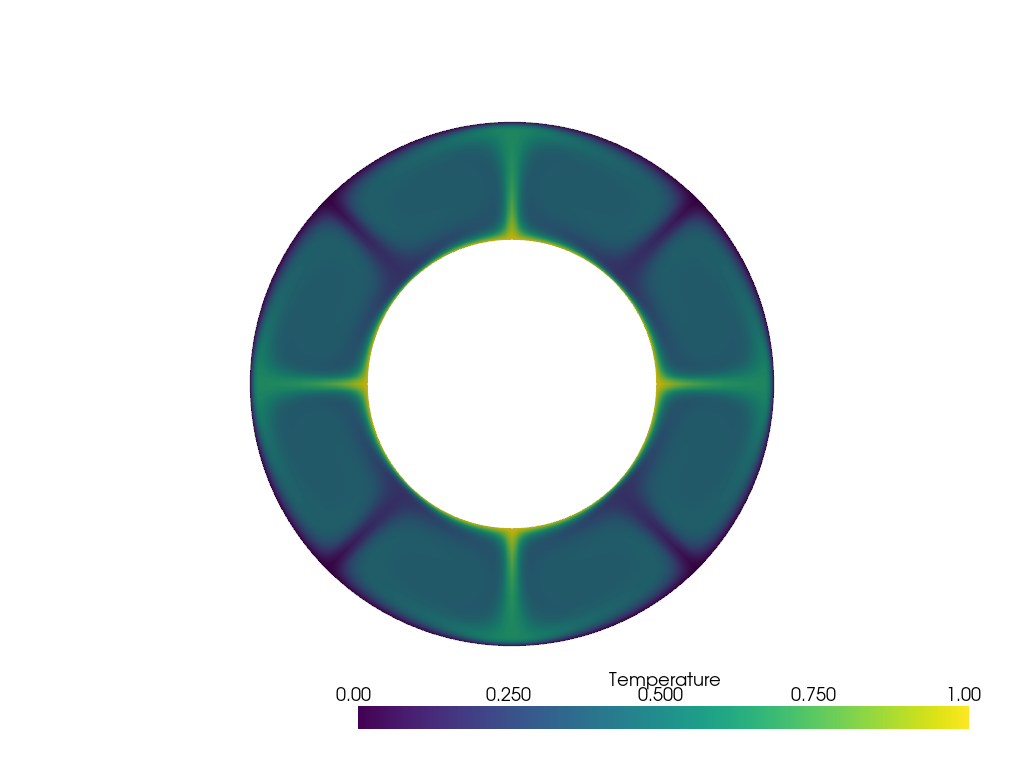

In [16]:
VTKFile("temp.pvd").write(T)
temp_data = pv.read("temp/temp_0.vtu")
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(temp_data)
plotter.camera_position = "xy"
plotter.show(jupyter_backend="static", interactive=False)